# Create figures in the Py-Feat paper.

*Written by Jin Hyun Cheong*

In [ ]:
!pip install -q py-feat

First, we download the necessary files & videos. 

## Figure 1

Loading Face Detection model:  retinaface
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/mobilenet0.25_Final.pth
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/mobilenet_224_model_best_gdconv_external.pth.tar
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/RF_568.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/ResMaskNet_Z_resmasking_dropout1_rot30

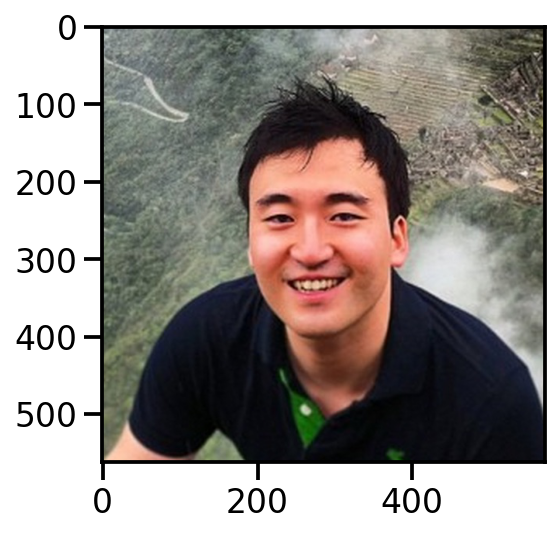

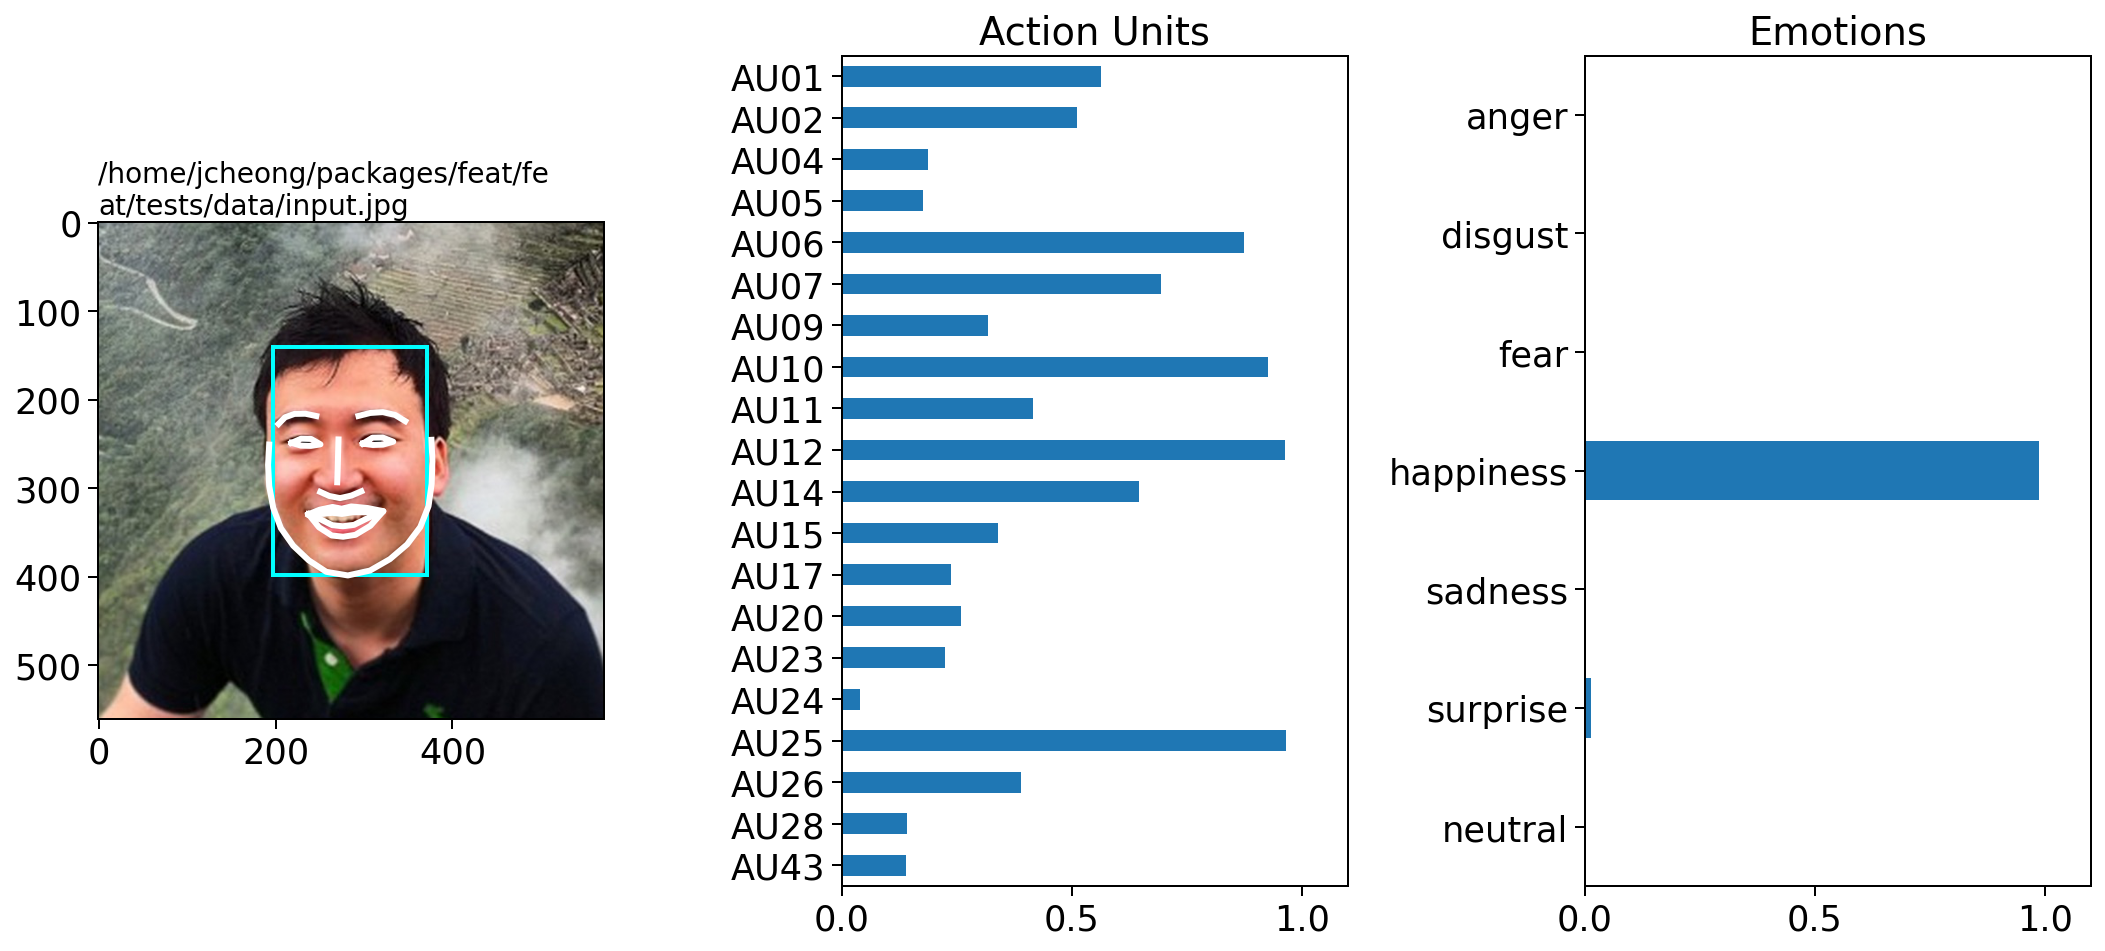

<AxesSubplot:>

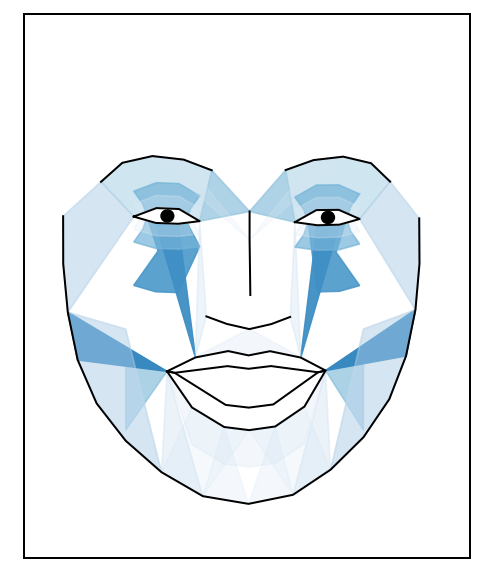

In [165]:
from feat import Detector
face_model = "retinaface"
landmark_model = "mobilenet"
au_model = "rf"
emotion_model = "resmasknet"
detector = Detector(face_model = face_model, landmark_model = landmark_model, au_model = au_model, emotion_model = emotion_model)

# Find the file you want to process.
from feat.tests.utils import get_test_data_path
import os
test_data_dir = get_test_data_path()
test_image = os.path.join(test_data_dir, "input.jpg")

from PIL import Image
import matplotlib.pyplot as plt
f, ax = plt.subplots()
im = Image.open(test_image)
ax.imshow(im)

image_prediction = detector.detect_image(test_image)

image_prediction.plot_detections()

image_prediction.detector = "feat"
image_prediction.plot_aus(row_n=0, muscles = {'all': 'heatmap'})

<AxesSubplot:>

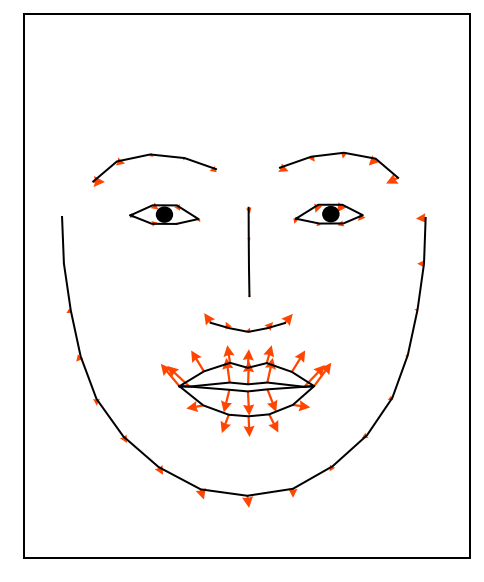

In [177]:
from feat.plotting import plot_face, predict
import numpy as np, seaborn as sns

image_prediction.detector = "feat"
feats = [
        "AU01",
        "AU02",
        "AU04",
        "AU05",
        "AU06",
        "AU07",
        "AU09",
        "AU10",
        "AU12",
        "AU14",
        "AU15",
        "AU17",
        "AU18",
        "AU20",
        "AU23",
        "AU24",
        "AU25",
        "AU26",
        "AU28",
        "AU43",
        ]
au = []
row_n = 0
for feat in feats:
    if feat=="AU18":
        au.append(0)
    else:
        aun = image_prediction[feat]
        au.append(aun.copy()[row_n])

neutral = predict(np.zeros(len(au)))
vectors = {'target': predict(1.5*np.array(au)), 'reference':  neutral, 
           'color': 'orangered', "headlength": 5, "headwidth": 5, "width":.005}
plot_face(au=np.zeros(20), vectorfield=vectors)

In [191]:
# Find the file you want to process.
from feat.tests.utils import get_test_data_path
import os, glob
test_data_dir = get_test_data_path()
test_video = os.path.join(test_data_dir, "WolfgangLanger_Pexels.mp4")
video_prediction = detector.detect_video(test_video)

exception occurred


In [ ]:
import seaborn as sns
from natsort import natsorted
import numpy as np

video_prediction.sampling_freq = 24
wavelets = video_prediction.aus().dropna().extract_multi_wavelet(min_freq = 0.06, bank=10,
                                                                 max_freq = .2, mode="filtered")
wavelets.columns = [col.split("_")[-1] + "_" + col.split("_")[0]  for col in wavelets.columns]
wavelets = wavelets[np.sort(wavelets.columns)]

sns.set_style("white")
newcols = [] 
for col in wavelets.columns:
    if "AU01" not in col and "AU02" not in col and "AU04" not in col and "AU05" not in col and "AU09" not in col and "AU11" not in col and "AU43" not in col:
    newcols.append(col)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(wavelets[newcols].T, cmap = 'RdBu_r', cbar=False, 
            xticklabels=False, yticklabels=False)
ax.set(xlabel = "", ylabel = "")

## Figure 2

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")

clip_attrs = pd.read_csv("clip_attrs.csv")
videos = np.sort(glob.glob("*.mp4"))

from feat.utils import read_feat
import pandas as pd

for ix ,video in enumerate(videos):
    outputF = video.replace(".mp4", ".csv")
    if ix == 0: 
        fex = read_feat(outputF)
    else:
        fex = pd.concat([fex, read_feat(outputF)])
fex = fex.dropna()

# Load in conditions
clip_attrs = pd.read_csv("clip_attrs.csv")
clip_attrs = clip_attrs.assign(input = clip_attrs.clipN.apply(lambda x: str(x).zfill(3)+".mp4"),
                               condition = clip_attrs['class'].replace({"gn":"goodNews", "ists":"badNews"}))
input_class_map = dict(zip(clip_attrs.input, clip_attrs['condition']))
clip_attrs.head()

In [180]:
average_au_intensity_per_video.sessions = average_au_intensity_per_video.index.map(input_class_map)
fig_df = average_au_intensity_per_video.reset_index()[["index", "mean_AU12","mean_AU17"]]
fig_df.columns = ['index', '12', '17']
fig_df = fig_df.melt(id_vars="index", 
                       value_vars= ['12', '17'],
                       var_name = "Action Units",
                       value_name = "Average probability")
fig_df = fig_df.assign(condition=fig_df['index'].map(input_class_map))

with sns.plotting_context("poster", font_scale=1.5):
    f,ax = plt.subplots(figsize=(5,8))
    sns.barplot(x="Action Units", y="Average probability", data=fig_df, hue='condition', ax=ax)
    ax.set(ylim=[0,1.2], yticks=[0, .5, 1.], ylabel="Average probability")
    sns.despine()
plt.legend(bbox_to_anchor=(1.7, .5), loc=9, borderaxespad=0., ncol=1, fontsize="x-large", frameon=False)

In [183]:
from sklearn.linear_model import LogisticRegression

from numpy.random import default_rng
average_au_intensity_per_video
ys = np.array(["goodNews"]*10 + ["badNews"]*10)
ys = pd.DataFrame({"y": ys}, index = average_au_intensity_per_video.index)

rng = default_rng(1)
goodNewsIdx = list(average_au_intensity_per_video.index[:10])
rng.shuffle(goodNewsIdx)
badNewsIdx = list(average_au_intensity_per_video.index[10:])
rng.shuffle(badNewsIdx)

scores = []
clfs = []
for rowix, row in average_au_intensity_per_video.iterrows():
    trainX = average_au_intensity_per_video.query("index!=@rowix")
    trainY = ys.query("index!=@rowix").values.ravel()

    testX = average_au_intensity_per_video.query("index==@rowix")
    testY = ys.query("index==@rowix").values.ravel()

    clf = trainX.predict(X = trainX.au_columns, y = trainY, model = LogisticRegression, penalty="none")
    scores.append(clf.score(testX.aus(), testY))
    clfs.append(clf.coef_[0])

clf = average_au_intensity_per_video.predict(average_au_intensity_per_video.au_columns, 
                                             ys.values.ravel(), 
                                             model = LogisticRegression, penalty="none")
print("scores:", scores)
print(f"coefficients for predicting class: {clf.classes_[1]}")
display(pd.DataFrame(clf.coef_, columns = fex.aus().columns))

scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
coefficients for predicting class: goodNews


AU01      AU02      AU04       AU05       AU06      AU07      AU09  \
0 -3.015825 -2.218453 -4.123036 -14.848985  13.295041  7.635223  3.481937   

      AU10      AU11       AU12      AU14      AU15      AU17      AU20  \
0  9.63488 -3.534334  16.668575 -3.263449  3.498912  3.299766  0.286058   

       AU23      AU24      AU25      AU26      AU28      AU43  
0 -1.400381 -7.996929  1.241669  0.736183 -0.702179  1.783518

In [185]:
coefdf = pd.DataFrame(clf.coef_, columns = fex.aus().columns).T
with sns.plotting_context("poster", font_scale=1.5):
    f,ax= plt.subplots(figsize=(1,7))
    sns.heatmap(coefdf[:10], 
                center=0, cmap="RdBu_r", annot=False, xticklabels=False, vmin=-15, vmax=15)
    f,ax= plt.subplots(figsize=(1,7))
    sns.heatmap(coefdf[10:], 
                center=0, cmap="RdBu_r", annot=False, xticklabels=False, vmin=-15, vmax=15)

<AxesSubplot:>

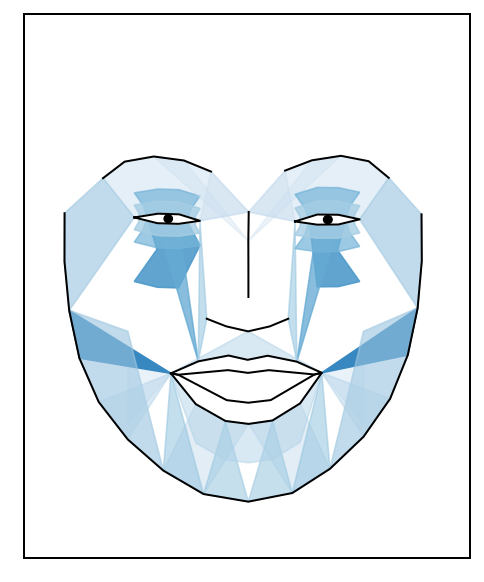

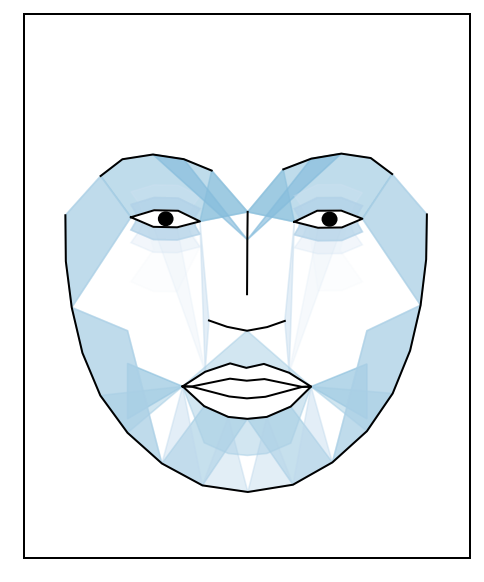

In [188]:
from feat import Fex
aus = Fex(pd.DataFrame(clf.coef_, columns = fex.aus().columns), 
          au_columns = fex.aus().columns,
         detector="feat")
aus.plot_aus(0, feature_range=(0,1), muscles = {'all': 'heatmap'})

aus = Fex(pd.DataFrame(-clf.coef_, columns = fex.aus().columns), 
          au_columns = fex.aus().columns,
         detector="feat")
aus.plot_aus(0, feature_range=(0,1), muscles = {'all': 'heatmap'})

## Figure 1 Analysis plots

T-test between goodNews vs badNews: t=17, p=2.32e-12


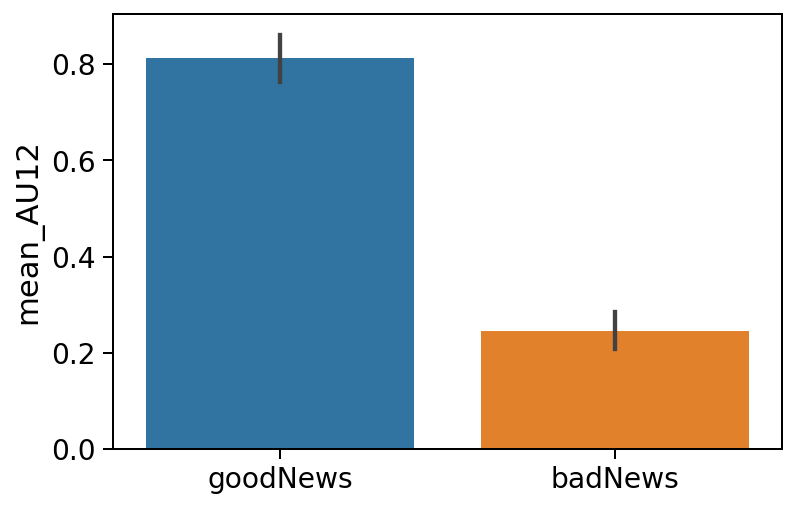

In [195]:
columns2compare = "mean_AU12"
sessions = ("goodNews", "badNews")
t, p = average_au_intensity_per_video.ttest_ind(col = columns2compare, sessions=sessions)
print(f"T-test between {sessions[0]} vs {sessions[1]}: t={t:.2g}, p={p:.3g}")
sns.barplot(x = average_au_intensity_per_video.sessions, 
            y = columns2compare, 
            data = average_au_intensity_per_video);

In [189]:
fex.sessions = fex.input()
isc = fex.isc(col = "AU01")
sns.heatmap(isc.corr(), center=0, vmin=-1, vmax=1, cmap="RdBu_r");

## Figure 3

In [193]:
intensity = 2
feature_range = (0,2)

f,axes = plt.subplots(1, 4, figsize=(15,4))
ax = axes[0]
import seaborn as sns
sns.set_context("paper", font_scale=1.6)
# Add data, AU is ordered as such: 
# AU 1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 25, 26, 28, 43

# Activate AU1: Inner brow raiser 
au = np.array([intensity, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
vectors = {'target': predict(au, feature_range=feature_range),
           'reference':  neutral, 'color': 'blue',
          'color': 'orangered', "headlength": 5, "headwidth": 5, "width":.005}

plot_face(model=None, vectorfield = None, muscles = {'all': 'heatmap'}, feature_range=feature_range,
          ax = ax, au = np.array(au), color='k', linewidth=1, linestyle='-')
ax.set_title("AU1: Inner brow raiser")

ax = axes[1]
au = np.array([0, 0, 0, 0, 0, 0, 0, 0, intensity, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
vectors = {'target': predict(au, feature_range=feature_range),
           'reference':  neutral, 'color': 'blue',
          'color': 'orangered', "headlength": 5, "headwidth": 5, "width":.005}

plot_face(model=None, vectorfield = None, muscles = {'all': 'heatmap'},feature_range=feature_range,
          ax = ax, au = np.array(au), color='k', linewidth=1, linestyle='-')
ax.set_title("AU12: Lip corner puller")

ax = axes[2]
au = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, intensity, 0, 0, 0, 0, 0, 0, 0, 0, 0])
vectors = {'target': predict(au, feature_range=feature_range),
           'reference':  neutral, 'color': 'blue',
          'color': 'orangered', "headlength": 5, "headwidth": 5, "width":.005}
plot_face(model=None, vectorfield = None, muscles = {'all': 'heatmap'},feature_range=feature_range,
          ax = ax, au = np.array(au), color='k', linewidth=1, linestyle='-')
ax.set_title("AU15: Lip corner depressor")

ax = axes[3]
au = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, intensity])
vectors = {'target': predict(au, feature_range=feature_range),
           'reference':  neutral, 'color': 'blue',
          'color': 'orangered', "headlength": 5, "headwidth": 5, "width":.005}

plot_face(model=None, vectorfield = None, muscles = {'all': 'heatmap'},feature_range=feature_range,
          ax = ax, au = np.array(au), color='k', linewidth=1, linestyle='-')
ax.set_title("AU43: Eye closer")

Text(0.5, 1.0, 'AU43: Eye closer')

Loading Face Detection model:  retinaface
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/mobilenet0.25_Final.pth
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/mobilenet_224_model_best_gdconv_external.pth.tar
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/RF_568.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/ResMaskNet_Z_resmasking_dropout1_rot30

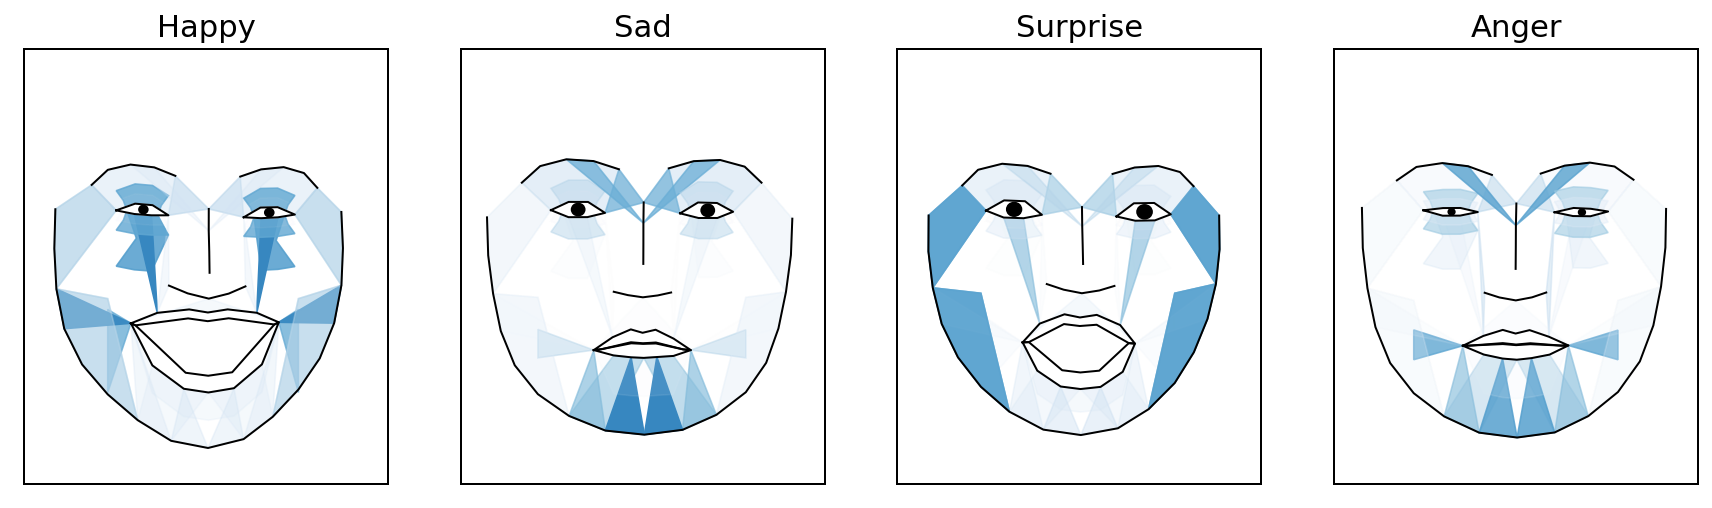

In [194]:
from feat import Detector
from feat.plotting import plot_face, predict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
detector = Detector()
aus = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 25, 26, 28, 43]
aulist = [f"AU"+str(au).zfill(2) for au in aus]

au = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
neutral = predict(np.zeros(len(au)))

# happy
imgfile = "/Storage/Data/CK+/cohn-kanade-images/S010/006/S010_006_00000008.png"
img = Image.open(imgfile)
out = detector.detect_image(imgfile)
happyau = out.aus().assign(AU18=0)[aulist].values[0]

# sadness
imgfile = "/Storage/Data/CK+/cohn-kanade-images/S011/002/S011_002_00000008.png"
out = detector.detect_image(imgfile)
sadau = out.aus().assign(AU18=0)[aulist].values[0]

# surprise
imgfile = "/Storage/Data/CK+/cohn-kanade-images/S010/002/S010_002_00000008.png"
out = detector.detect_image(imgfile)
surpriseau = out.aus().assign(AU18=0)[aulist].values[0]

# fear
imgfile = "/Storage/Data/CK+/cohn-kanade-images/S011/003/S011_003_00000008.png"
out = detector.detect_image(imgfile)
fearau = out.aus().assign(AU18=0)[aulist].values[0]

#disgust 
imgfile = "/Storage/Data/CK+/cohn-kanade-images/S005/001/S005_001_00000008.png"
out = detector.detect_image(imgfile)
disgustau = out.aus().assign(AU18=0)[aulist].values[0]

# anger
imgfile = "/Storage/Data/CK+/cohn-kanade-images/S010/004/S010_004_00000012.png"
out = detector.detect_image(imgfile)
angerau = out.aus().assign(AU18=0)[aulist].values[0]

f,axes = plt.subplots(1, 4, figsize=(15,4))
titles = ['Happy', "Sad", "Surprise", "Anger"]
for ix, au in enumerate([happyau, sadau, surpriseau, angerau]):
    ax = axes[ix]
    vectors = {'target': predict(au),
               'reference':  neutral, 
              'color': 'orangered', "headlength": 5, "headwidth": 5, "width":.005}
    plot_face(model=None, vectorfield = None, muscles = {'all': 'heatmap'},
              ax = ax, au = np.array(au), color='k', linewidth=1, linestyle='-', feature_range=(0,2))
    ax.set(title = titles[ix])